In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spspa
import scipy.sparse.linalg as spspala
from matplotlib import cm
import matplotlib.pyplot as plt
import time
from hlsvdpro.propack import svdp

## Randomized SVD

In [2]:
def compressed_svd(a, r, p=20, return_v=False):
    omega = np.random.rand(a.shape[1], r+p)
    x = a.dot(omega)
    q, _ = np.linalg.qr(x)
    b = q.T.dot(a)
    if return_v:
        u, s, v = svdp(b, k=r, compute_v = return_v)
    else:
        u, s= svdp(b, k=r, compute_v = return_v)
        v = None
    
    return q.dot(u), s, v

## Parameters and initial conditions

In [3]:
n_t = 10000

t_max = 5
dt = t_max/n_t
x_max = 1
y_max = 1
n_x = 100
n_y = 100

dx = x_max/n_x
dy = y_max/n_y
theta = 0.1
mu = 30
x = np.linspace(x_max/n_x*0.5, x_max-x_max/n_x*0.5, n_x)
y = np.linspace(y_max/n_y*0.5, y_max-y_max/n_y*0.5, n_y)

xx, yy = np.meshgrid(x, y)
u0 = np.zeros(xx.shape)
u0[np.logical_and(xx*yy>0.1, xx*yy<0.6)] = 0.1

## Solve Equations

In [4]:
def solve_equation(u_0, theta, mu, n_x, n_y, dx, dy, dt, n_step):
    # compose matrix
    d0 = 1/dt + 2*theta/(dx*dx) + 2*theta/(dy*dy)
    d1 = -theta/(dx*dx)
    dn = -theta/(dy*dy)
    mat = spspa.diags((dn, d1, d0, d1, dn), (-n_x, -1, 0, 1, n_x), shape=(n_x*n_y, n_x*n_y), format='lil')
    for i in range(n_x,n_x*n_y,n_x):
        mat[i, i-1] = 0
        mat[i-1, i] = 0
    mat = mat.tocsc()
    mat.eliminate_zeros()
    
    #solve equation    
    res = [u_0.reshape(-1)]
    lu = spspala.splu(mat)
    nl = []
    for i in range(n_step):
        nl.append(mu*res[-1] - mu*(res[-1]**3))
        rhs = res[-1] / dt + nl[-1]
        res.append(lu.solve(rhs))
        
    return np.stack(res, axis=1), np.stack(nl, axis=1)

In [5]:
%%time
snapshots, nl_snapshots = solve_equation(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t)

CPU times: user 22.7 s, sys: 2.2 s, total: 24.9 s
Wall time: 23.9 s


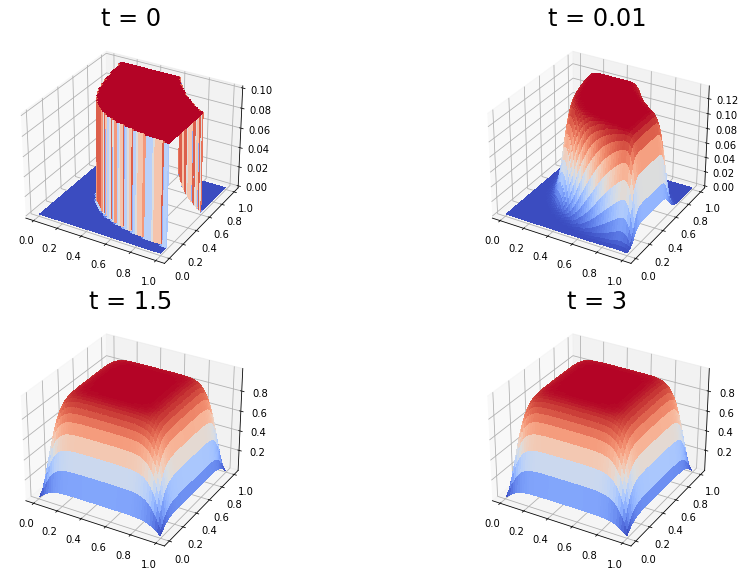

In [6]:
t_int = [0, 0.01, 1.5, 3]
plt.figure(figsize=(16,8))
for j, t in enumerate(t_int):

    i = int(t/dt)
    ax = plt.subplot(2, 2, j+1, projection='3d')

#     ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx, yy, snapshots[:, i].reshape(100, 100), 
                           linewidth=0, antialiased=False, cmap=cm.coolwarm)
    plt.title('t = {}'.format(t), fontsize=24)
plt.tight_layout()
plt.savefig('eq_results.png')
plt.savefig('eq_results.pdf')

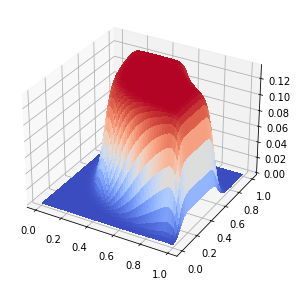

In [8]:
t= 0.01
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, snapshots[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('eq_results_0_01.pdf')

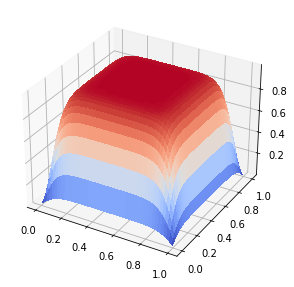

In [9]:
t= 3
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, snapshots[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('eq_results_3.pdf')

## POD-Galerkin method

In [10]:
def solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_step, snapshots, r, compressed=False, p=20):
    # compose matrix
    d0 = 1/dt + 2*theta/(dx*dx) + 2*theta/(dy*dy)
    d1 = -theta/(dx*dx)
    dn = -theta/(dy*dy)
    mat = spspa.diags((dn, d1, d0, d1, dn), (-n_x, -1, 0, 1, n_x), shape=(n_x*n_y, n_x*n_y), format='lil')
    for i in range(n_x,n_x*n_y,n_x):
        mat[i, i-1] = 0
        mat[i-1, i] = 0
    mat = mat.tocsc()
    mat.eliminate_zeros()
    
    # build pod basis
    if compressed:
        u, s, _ = compressed_svd(snapshots, r, p)
    else:
        u, s, = svdp(snapshots, r, compute_v=False )
    indices = np.argsort(-s)
    pod_basis = u[:, indices]
    mat_r = pod_basis.T.dot(mat.dot(pod_basis))
    
    # solve equation
    res = [u0.reshape(-1)]
    nl = []
    lu, piv = sp.linalg.lu_factor(mat_r)
    for i in range(n_step):
        nl.append(mu*res[-1] - mu*(res[-1]**3))
        rhs = res[-1] / dt + nl[-1]
        a_r = sp.linalg.lu_solve((lu, piv), pod_basis.T.dot(rhs))
        res.append(pod_basis.dot(a_r))
        
    return np.stack(res, axis=1)

In [11]:
%%time
r = 10
res = solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r)

CPU times: user 43 s, sys: 29.2 s, total: 1min 12s
Wall time: 12.7 s


In [12]:
%%time
r = 10
res = solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r, compressed=True)

CPU times: user 29.7 s, sys: 30 s, total: 59.7 s
Wall time: 11.8 s


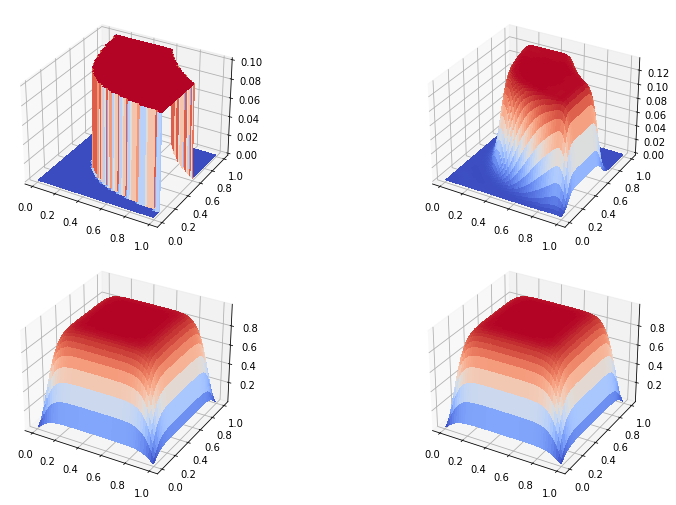

In [13]:
t_int = [0, 0.01, 1.5, 3]
plt.figure(figsize=(14,7))
for j, t in enumerate(t_int):

    i = int(t/dt)
    ax = plt.subplot(2, 2, j+1, projection='3d')
    surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                           linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

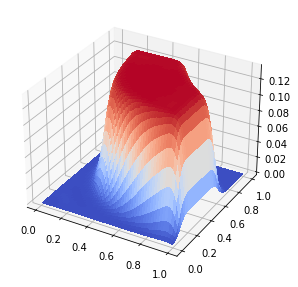

In [14]:
t= 0.01
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('pod_results_0_01.pdf')

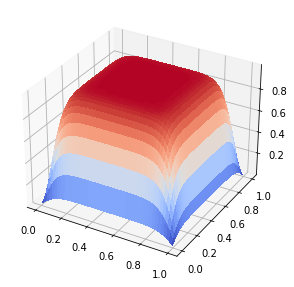

In [15]:
t= 3
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('pod_results_3.pdf')

## POD-DEIM 

In [16]:
def solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_step, snapshots, r, nl_snapshots, r2=20, compressed=False, p=20):
    # note: the rank of the reduced system is r + r2
    
    # compose matrix
    d0 = 1/dt + 2*theta/(dx*dx) + 2*theta/(dy*dy)
    d1 = -theta/(dx*dx)
    dn = -theta/(dy*dy)
    mat = spspa.diags((dn, d1, d0, d1, dn), (-n_x, -1, 0, 1, n_x), shape=(n_x*n_y, n_x*n_y), format='lil')
    for i in range(n_x,n_x*n_y,n_x):
        mat[i, i-1] = 0
        mat[i-1, i] = 0
    mat = mat.tocsc()
    mat.eliminate_zeros()
    
    # calculate state basis
    if compressed:
        u, s, _ = compressed_svd(snapshots, r)
    else:
        u, s  = svdp(snapshots, r, compute_v=False)
    indices = np.argsort(-s)
    state_basis = u[:, indices]
    
    # calculate basis for nonlinear snapshots
    reduced_nl = state_basis.dot(state_basis.T.dot(nl_snapshots))
    if compressed:
        u, s, _ = compressed_svd(reduced_nl, r=r)
    else:
        u, s = svdp(reduced_nl, r, compute_v=False)
    indices = np.argsort(-s)
    nl_basis = u[:, indices]
    
    # calculate projection matrix (DEIM)        
    s_sorted = s[indices]
    r2 = r
#     while cond>50:
#         s_sorted = s[:-1]
#         cond = s_sorted[0] / s_sorted[-1]
#         r2 = r2 - 1
    p = np.zeros((nl_basis.shape[0], r2))
    p[np.argmax(np.abs(nl_basis[0, :])), 0] = 1
    
    for l in range(1, r2):
#         c = np.linalg.solve(p[:, :l].T.dot(nl_basis[:,:l]), p[:, :l].T.dot(nl_basis[:,l]))
        c = np.linalg.pinv(p[:, :l].T.dot(nl_basis[:,:l])).dot(p[:, :l].T.dot(nl_basis[:,l]))
        ind = np.argmax(np.abs(nl_basis[:,l] - nl_basis[:,:l].dot(c)))
        p[ind, l] = 1
        
    pod_basis = state_basis
    
    mat_r = pod_basis.T.dot(mat.dot(pod_basis))
    
    lu, piv = sp.linalg.lu_factor(mat_r)
    # project to pod domain
    nl_proj = np.linalg.pinv(p.T.dot(pod_basis))
    # project back
    nl_proj2 = p.T.dot(pod_basis)
    
    res = [pod_basis.T.dot(u0.reshape(-1))]
    nl = []
    for i in range(n_t):
        a = nl_proj2.dot(res[-1])

        nl.append(nl_proj.dot(mu*(a-a**3)))
        rhs = res[-1] / dt + nl[-1]

        a_r = sp.linalg.lu_solve((lu, piv), rhs)
        res.append(a_r)
        
    return pod_basis.dot(np.stack(res, axis=1))
    

In [17]:
%%time
r = 10
res = solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r, nl_snapshots)

CPU times: user 1min 2s, sys: 17.7 s, total: 1min 20s
Wall time: 15.2 s


In [18]:
%%time
r = 10
res = solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r, nl_snapshots, compressed=True)

CPU times: user 15 s, sys: 6.52 s, total: 21.5 s
Wall time: 4.86 s


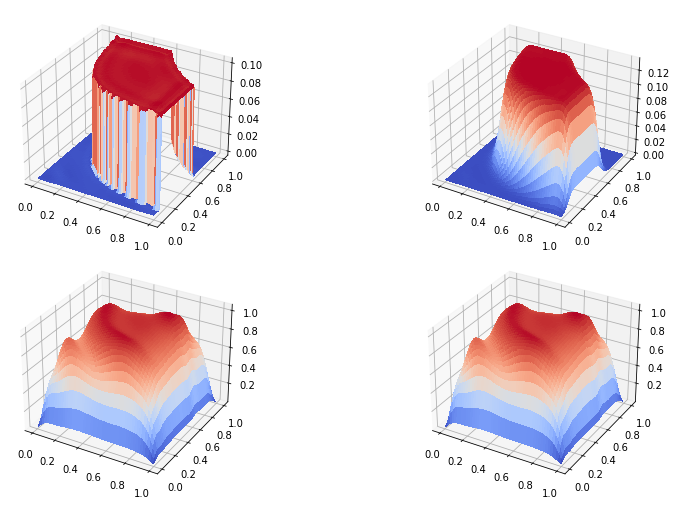

In [19]:
t_int = [0, 0.01, 1.5, 3]
plt.figure(figsize=(14,7))
for j, t in enumerate(t_int):

    i = int(t/dt)
    ax = plt.subplot(2, 2, j+1, projection='3d')

#     ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                           linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

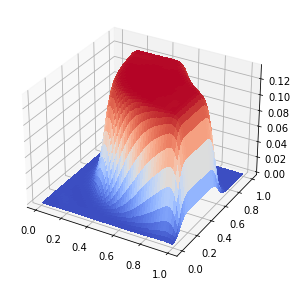

In [23]:
t= 0.01
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('pod_deim_results_0_01.pdf')

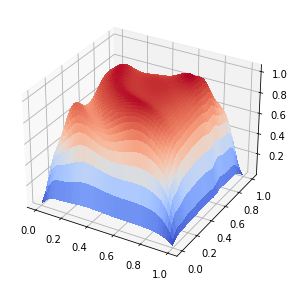

In [20]:
t= 3
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('pod_deim_results_3.pdf')

In [21]:
## DMD

In [22]:
def solve_equation_dmd(u0, n_t, snapshots0, snapshots1, r, compressed=False, p=20):
    if compressed:
        u,s, v = compressed_svd(snapshots0, r, p=20, return_v=True)
    else:
        u, s, v = svdp(snapshots0, r)
    a_tilde = u.T.dot(snapshots1).dot(v.T).dot(np.linalg.pinv(np.diag(s)))
    
    res = [u.T.dot(u0.reshape(-1))]

    for i in range(n_t):
        res.append(a_tilde.dot(res[-1]))
        
    return u.dot(np.stack(res, axis=1))
    

In [23]:
%%time
r = 10
snapshots0 = snapshots[:, :-1]
res = solve_equation_dmd(u0, n_t, snapshots0, snapshots[:, 1:], r)

CPU times: user 1min 1s, sys: 1min, total: 2min 1s
Wall time: 59.4 s


In [24]:
%%time
r = 10
res = solve_equation_dmd(u0, n_t, snapshots0, snapshots[:, 1:], r, compressed=True)

CPU times: user 11.4 s, sys: 6.81 s, total: 18.2 s
Wall time: 4.61 s


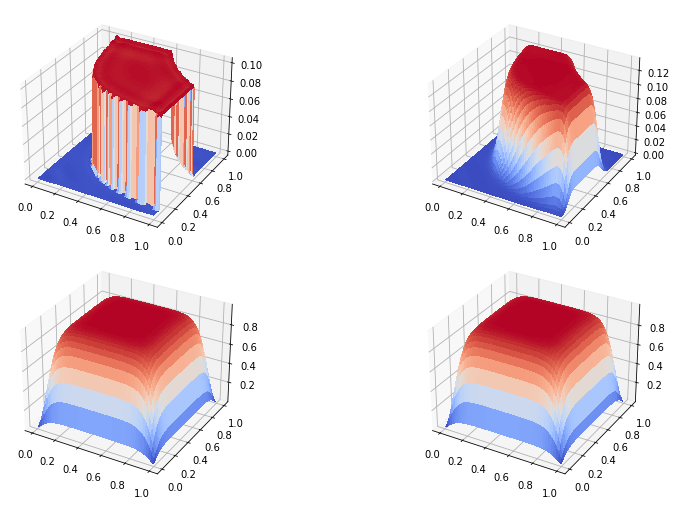

In [25]:
t_int = [0, 0.01, 1.5, 3]
plt.figure(figsize=(14,7))
for j, t in enumerate(t_int):

    i = int(t/dt)
    ax = plt.subplot(2, 2, j+1, projection='3d')

    surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                           linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

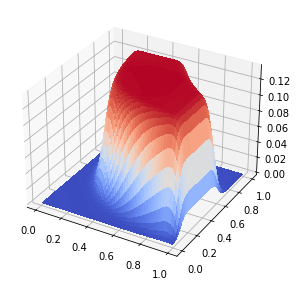

In [26]:
t= 0.01
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('dmd_results_0_01.pdf')

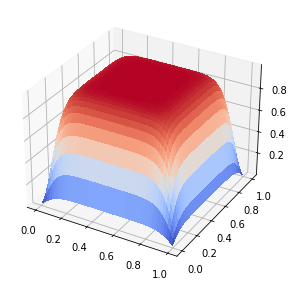

In [27]:
t= 3
i = int(t/dt)
ax = plt.figure().gca(projection='3d')

#     ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, res[:, i].reshape(100, 100), 
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
plt.tight_layout()

plt.savefig('dmd_results_3.pdf')

In [ ]:
ranks = range(1, 25)
solvers = {
    'POD': lambda r: solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots,
                                        r, compressed=False),
    'rPOD': lambda r: solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots,
                                         r, compressed=True),
    'POD-DEIM': lambda r: solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r,
                                                  nl_snapshots, r2=4*r),
    'rPOD-rDEIM': lambda r: solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r,
                                                    nl_snapshots, r2=4*r, compressed=True),
    'DMD': lambda r: solve_equation_dmd(u0, n_t,snapshots0, snapshots[:, 1:], r),
    'cDMD': lambda r: solve_equation_dmd(u0, n_t, snapshots0, snapshots[:, 1:], r, compressed=True)
    
}

snapshots_norm = np.linalg.norm(snapshots[:, 1:])

err = {}

el_time = {}

for name, solver in solvers.items():
    el_time[name] = []
    err[name] = []
    for r in ranks:
        start = time.time()
        res = solver(r)
        end = time.time()
        el_time[name].append(end-start)
        err[name].append(np.linalg.norm(res[:, 1:] - snapshots[:, 1:])/snapshots_norm)
        print(name, r)
        

POD 1
POD 2
POD 3
POD 4
POD 5
POD 6
POD 7
POD 8
POD 9
POD 10
POD 11
POD 12
POD 13
POD 14
POD 15
POD 16
POD 17
POD 18
POD 19
POD 20
POD 21
POD 22
POD 23
POD 24
rPOD 1
rPOD 2
rPOD 3
rPOD 4
rPOD 5
rPOD 6
rPOD 7
rPOD 8
rPOD 9
rPOD 10
rPOD 11
rPOD 12
rPOD 13
rPOD 14
rPOD 15
rPOD 16
rPOD 17
rPOD 18
rPOD 19
rPOD 20
rPOD 21
rPOD 22
rPOD 23
rPOD 24
POD-DEIM 1
POD-DEIM 2
POD-DEIM 3
POD-DEIM 4
POD-DEIM 5
POD-DEIM 6
POD-DEIM 7
POD-DEIM 8
POD-DEIM 9
POD-DEIM 10
POD-DEIM 11
POD-DEIM 12
POD-DEIM 13
POD-DEIM 14
POD-DEIM 15
POD-DEIM 16
POD-DEIM 17
POD-DEIM 18
POD-DEIM 19
POD-DEIM 20
POD-DEIM 21
POD-DEIM 22
POD-DEIM 23
POD-DEIM 24
rPOD-rDEIM 1
rPOD-rDEIM 2
rPOD-rDEIM 3
rPOD-rDEIM 4
rPOD-rDEIM 5
rPOD-rDEIM 6
rPOD-rDEIM 7
rPOD-rDEIM 8
rPOD-rDEIM 9
rPOD-rDEIM 10
rPOD-rDEIM 11
rPOD-rDEIM 12
rPOD-rDEIM 13
rPOD-rDEIM 14
rPOD-rDEIM 15
rPOD-rDEIM 16
rPOD-rDEIM 17
rPOD-rDEIM 18
rPOD-rDEIM 19
rPOD-rDEIM 20
rPOD-rDEIM 21
rPOD-rDEIM 22
rPOD-rDEIM 23
rPOD-rDEIM 24
DMD 1
DMD 2
DMD 3
DMD 4
DMD 5
DMD 6
DMD 7
DMD 8
DMD 

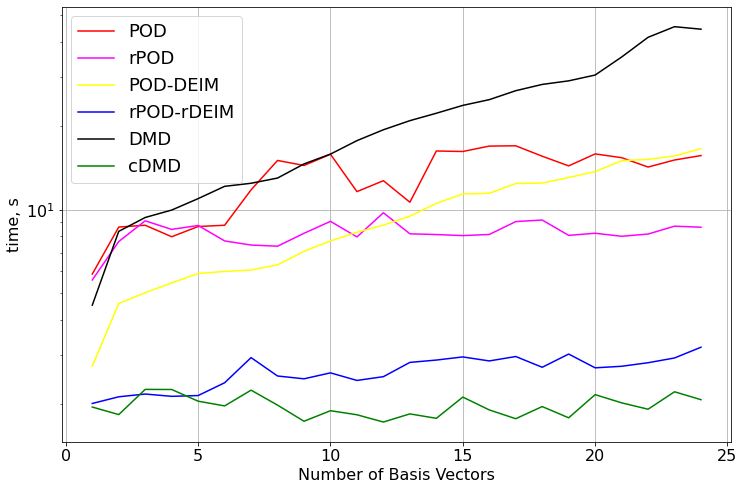

In [56]:
plt.figure(figsize=[12,8])
color_map ={
    'POD': 'red',
    'rPOD': 'magenta',
    'POD-DEIM': 'yellow',
    'rPOD-rDEIM': 'blue',
    'DMD': 'black',
    'cDMD': 'green',
}
for name, t in el_time.items():
    plt.semilogy(ranks, t, label=name, color=color_map[name])
plt.legend(fontsize=18)
plt.xlabel('Number of Basis Vectors', fontsize = 16);
plt.ylabel('time, s', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.title('', fontsize=20);
plt.grid()
plt.savefig('time.png')

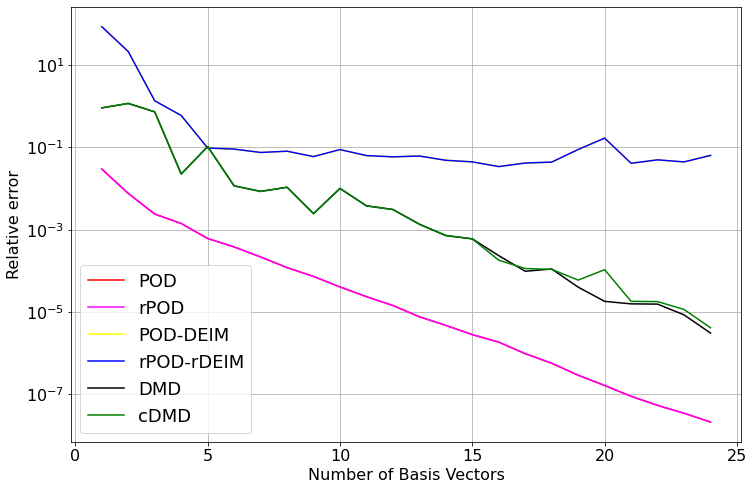

In [59]:
plt.figure(figsize=[12,8])
color_map ={
    'POD': 'red',
    'rPOD': 'magenta',
    'POD-DEIM': 'yellow',
    'rPOD-rDEIM': 'blue',
    'DMD': 'black',
    'cDMD': 'green',
}
for name, e in err.items():
    plt.semilogy(ranks, e, label=name, color=color_map[name])
plt.legend(fontsize=18)
plt.xlabel('Number of Basis Vectors', fontsize = 16);
plt.ylabel('Relative error', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.title('', fontsize=20);
plt.grid()
plt.savefig('err.png')

In [47]:
n_range = range(10, 101, 10)
r = 10
solvers = {
    'POD': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_pod(u0,
                                                                               theta,
                                                                               mu,
                                                                               n_x,
                                                                               n_y,
                                                                               dx,
                                                                               dy,
                                                                               dt,
                                                                               n_t,
                                                                               snapshots,
                                                                               r,
                                                                               compressed=False),
    'rPOD': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_pod(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots,
                                         r, compressed=True),
    'POD-DEIM': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r,
                                                  nl_snapshots, r2=20),
    'rPOD-rDEIM': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_pod_deim(u0, theta, mu, n_x, n_y, dx, dy, dt, n_t, snapshots, r,
                                                    nl_snapshots, r2=20, compressed=True),
    'DMD': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_dmd(u0, n_t, snapshots0, snapshots[:, 1:], r),
    'cDMD': lambda u0, n_x, n_y, dx, dy, dt, n_t, snapshots, snapshots0, nl_snapshots: solve_equation_dmd(u0, n_t, snapshots0, snapshots[:, 1:], r, compressed=True)
    
}

err_n = {}

el_time_n = {}

for name, solver in solvers.items():
    el_time_n[name] = []
    err_n[name] = []

for n in n_range:
    n_t = n*n
    dt = t_max/n_t
    n_x = n
    n_y = n
    dx = x_max/n_x
    dy = y_max/n_y
    x = np.linspace(x_max/n_x*0.5, x_max-x_max/n_x*0.5, n_x)
    y = np.linspace(y_max/n_y*0.5, y_max-y_max/n_y*0.5, n_y)

    xx, yy = np.meshgrid(x, y)
    u0 = np.zeros(xx.shape)
    u0[np.logical_and(xx*yy>0.1, xx*yy<0.6)] = 0.1
    snapshots_tmp, nl_snapshots_tmp = solve_equation(u0, theta, mu, n_x, n_y, dx,
                                                     dy, dt, n_t)
    snapshots0_tmp = snapshots_tmp[:, 0:-1]
    snapshots_norm = np.linalg.norm(snapshots_tmp[:, 1:])
    
    for name, solver in solvers.items():        
        start = time.time()
        res = solver(u0, n_x, n_y, dx, dy, dt, n_t, snapshots_tmp, snapshots0_tmp, nl_snapshots_tmp)
        end = time.time()
        el_time_n[name].append(end-start)
        err_n[name].append(np.linalg.norm(res[:, 1:] - snapshots_tmp[:, 1:])/snapshots_norm)
        print(name, n)
        

POD 10
rPOD 10
POD-DEIM 10
rPOD-rDEIM 10
DMD 10
cDMD 10
POD 20
rPOD 20
POD-DEIM 20
rPOD-rDEIM 20
DMD 20
cDMD 20
POD 30
rPOD 30
POD-DEIM 30
rPOD-rDEIM 30
DMD 30
cDMD 30
POD 40
rPOD 40
POD-DEIM 40
rPOD-rDEIM 40
DMD 40
cDMD 40
POD 50
rPOD 50
POD-DEIM 50
rPOD-rDEIM 50
DMD 50
cDMD 50
POD 60
rPOD 60
POD-DEIM 60
rPOD-rDEIM 60
DMD 60
cDMD 60
POD 70
rPOD 70
POD-DEIM 70
rPOD-rDEIM 70
DMD 70
cDMD 70
POD 80
rPOD 80
POD-DEIM 80
rPOD-rDEIM 80
DMD 80
cDMD 80
POD 90
rPOD 90
POD-DEIM 90
rPOD-rDEIM 90
DMD 90
cDMD 90
POD 100
rPOD 100
POD-DEIM 100
rPOD-rDEIM 100
DMD 100
cDMD 100


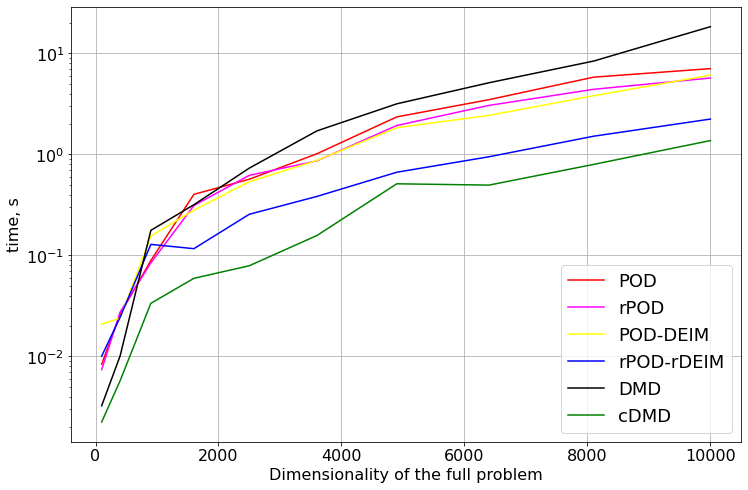

In [61]:
plt.figure(figsize=[12,8])
color_map ={
    'POD': 'red',
    'rPOD': 'magenta',
    'POD-DEIM': 'yellow',
    'rPOD-rDEIM': 'blue',
    'DMD': 'black',
    'cDMD': 'green',
}
for name, t in el_time_n.items():
    plt.semilogy(np.array(n_range)**2, t, label=name, color=color_map[name])
plt.legend(fontsize=18)
plt.xlabel('Dimensionality of the full problem', fontsize = 16);
plt.ylabel('time, s', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.title('', fontsize=20);
plt.grid()
plt.savefig('time_vs_dimensionality')

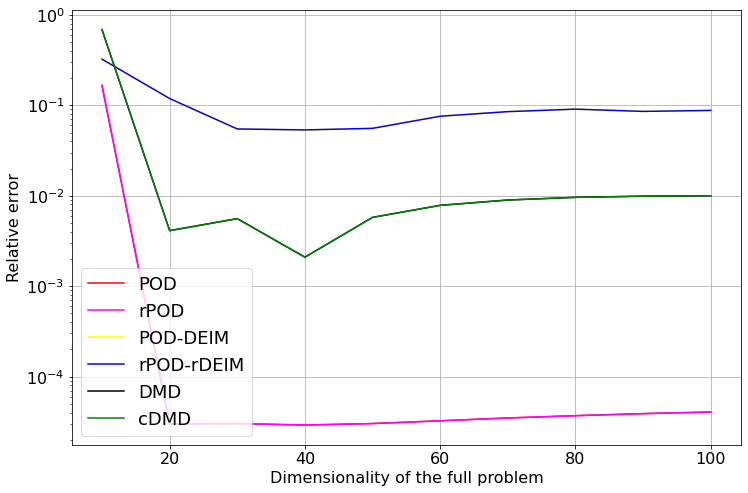

In [65]:
plt.figure(figsize=[12,8])
color_map ={
    'POD': 'red',
    'rPOD': 'magenta',
    'POD-DEIM': 'yellow',
    'rPOD-rDEIM': 'blue',
    'DMD': 'black',
    'cDMD': 'green',
}
for name, e in err_n.items():
    plt.semilogy(n_range, e, label=name, color=color_map[name])
plt.legend(fontsize=18)
plt.xlabel('Dimensionality of the full problem', fontsize = 16);
plt.ylabel('Relative error', fontsize = 16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.title('', fontsize=20);
plt.grid()
plt.savefig('err_vs_dimensionality.png')